# Workflow 
---
This notebook is a summarised version of the essential steps needed to train our model & generate a prediction. 
We assume using method 2 (column version) in this notebook. 

What you need for this notebook: 
- Original dataset 

The notebook contains 3 section: 
1. Data parsing & preprocessing (+ feature engineering & selection)
2. Model training 
3. Prediction 

We are using the weighted ensemble model.

## Section 1: Data Parsing & Preprocessing 

In [2]:
import json
import pandas as pd
import numpy as np

In [3]:
# !gzip -d dataset2.json.gz


In [4]:
data_list = []

with open('dataset0.json', 'r') as json_file:
    for line in json_file:
        data = json.loads(line)
        data_list.append(data)

In [5]:
def explore_dataset(data_list):
    results = []
    for data in data_list:
        trans_id, first = next(iter(data.items()))
        position, second = next(iter(first.items()))
        sequence, data = next(iter(second.items()))

        avg = np.mean(data, axis=0)
        med = np.median(data, axis=0)
    
        std = np.std(data, axis=0)

        result = [trans_id, position, sequence] + list(avg)+ list(med) + list(std)
        results.append(result)

    return results

In [6]:
results = explore_dataset(data_list)
result_df = pd.DataFrame(results)

In [7]:
result_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,ENST00000000233,244,AAGACCA,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,...,80.5,0.005384,1.843025,4.944365,0.005364,3.302671,2.765244,0.004566,2.906225,2.522168
1,ENST00000000233,261,CAAACTG,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,...,94.1,0.003588,1.689167,2.981182,0.003767,1.237045,3.526528,0.004528,1.466295,2.492530
2,ENST00000000233,316,GAAACAG,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,...,89.2,0.004444,1.311103,1.492577,0.005035,0.893481,3.203816,0.004497,0.800496,1.484341
3,ENST00000000233,332,AGAACAT,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006102,...,89.9,0.006121,2.459317,3.202963,0.004612,1.393868,1.928009,0.003595,0.741771,3.494937
4,ENST00000000233,368,AGGACAA,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,...,85.4,0.007151,2.743228,2.664643,0.005407,1.753894,2.177236,0.005908,1.341822,2.379045


In [8]:
colnames = ['transcript_id', 'transcript_position', 'sequence']
for i in ['avg', 'med','std']:
    for j in ['1-flank', 'central', '1+flank']:
        for q in ["length", "std", "mean"]:
            colnames.append(i + '_' + j + '_' + q)

result_df.columns = colnames

In [9]:
result_df['transcript_position'] = result_df['transcript_position'].astype(int)

In [10]:
result_df.head()

,transcript_id,transcript_position,sequence,avg_1-flank_length,avg_1-flank_std,avg_1-flank_mean,avg_central_length,avg_central_std,avg_central_mean,avg_1+flank_length,...,med_1+flank_mean,std_1-flank_length,std_1-flank_std,std_1-flank_mean,std_central_length,std_central_std,std_central_mean,std_1+flank_length,std_1+flank_std,std_1+flank_mean
0,ENST00000000233,244,AAGACCA,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,...,80.5,0.005384,1.843025,4.944365,0.005364,3.302671,2.765244,0.004566,2.906225,2.522168
1,ENST00000000233,261,CAAACTG,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,...,94.1,0.003588,1.689167,2.981182,0.003767,1.237045,3.526528,0.004528,1.466295,2.492530
2,ENST00000000233,316,GAAACAG,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,...,89.2,0.004444,1.311103,1.492577,0.005035,0.893481,3.203816,0.004497,0.800496,1.484341
3,ENST00000000233,332,AGAACAT,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006102,...,89.9,0.006121,2.459317,3.202963,0.004612,1.393868,1.928009,0.003595,0.741771,3.494937
4,ENST00000000233,368,AGGACAA,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,...,85.4,0.007151,2.743228,2.664643,0.005407,1.753894,2.177236,0.005908,1.341822,2.379045


In [11]:
df = result_df.copy() 
rfe = ['transcript_id',
'transcript_position',
'sequence',
'avg_central_mean',
'avg_1+flank_std',
'med_central_std',
'med_central_mean',
'med_1+flank_std',
'std_1-flank_std',
'std_1-flank_mean',
'std_central_std',
'std_central_mean',
'std_1+flank_std',
'std_1+flank_mean']
df = df[rfe]

In [12]:
df['seq_left'] = df['sequence'].str[0:5]
df['seq_center'] = df['sequence'].str[1:6]
df['seq_right'] = df['sequence'].str[2:7]

In [13]:
from sklearn.preprocessing import LabelEncoder
df_le = df.copy()
label_encoder = LabelEncoder()

seq_data = ['seq_left','seq_center','seq_right']
for seq in seq_data: 
    encoded_labels = label_encoder.fit_transform(df_le[seq])
    df_le[seq] = encoded_labels

df_le.head()

,transcript_id,transcript_position,sequence,avg_central_mean,avg_1+flank_std,med_central_std,med_central_mean,med_1+flank_std,std_1-flank_std,std_1-flank_mean,std_central_std,std_central_mean,std_1+flank_std,std_1+flank_mean,seq_left,seq_center,seq_right
0,ENST00000000233,244,AAGACCA,125.913514,4.386989,6.650,126.0,3.440,1.843025,4.944365,3.302671,2.765244,2.906225,2.522168,1,4,16
1,ENST00000000233,261,CAAACTG,107.889535,3.016599,3.000,108.0,2.660,1.689167,2.981182,1.237045,3.526528,1.466295,2.492530,6,2,10
2,ENST00000000233,316,GAAACAG,98.947027,2.087146,3.780,99.5,1.910,1.311103,1.492577,0.893481,3.203816,0.800496,1.484341,12,0,2
3,ENST00000000233,332,AGAACAT,97.836500,2.236520,2.635,97.5,2.135,2.459317,3.202963,1.393868,1.928009,0.741771,3.494937,2,6,3
4,ENST00000000233,368,AGGACAA,121.954545,4.260253,5.660,122.0,4.160,2.743228,2.664643,1.753894,2.177236,1.341822,2.379045,3,9,12


## Section 2: Model 

In [14]:
import xgboost as xgb
import pandas as pd
import numpy as np 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense

2023-11-05 19:41:24.149776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
test = df_le.copy()

In [16]:
X_test = test.drop(['transcript_id', 'sequence'], axis=1)
X_test.head()

,transcript_position,avg_central_mean,avg_1+flank_std,med_central_std,med_central_mean,med_1+flank_std,std_1-flank_std,std_1-flank_mean,std_central_std,std_central_mean,std_1+flank_std,std_1+flank_mean,seq_left,seq_center,seq_right
0,244,125.913514,4.386989,6.650,126.0,3.440,1.843025,4.944365,3.302671,2.765244,2.906225,2.522168,1,4,16
1,261,107.889535,3.016599,3.000,108.0,2.660,1.689167,2.981182,1.237045,3.526528,1.466295,2.492530,6,2,10
2,316,98.947027,2.087146,3.780,99.5,1.910,1.311103,1.492577,0.893481,3.203816,0.800496,1.484341,12,0,2
3,332,97.836500,2.236520,2.635,97.5,2.135,2.459317,3.202963,1.393868,1.928009,0.741771,3.494937,2,6,3
4,368,121.954545,4.260253,5.660,122.0,4.160,2.743228,2.664643,1.753894,2.177236,1.341822,2.379045,3,9,12


In [17]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(X_test)
normalised_X_test = pd.DataFrame(d, columns=X_test.columns)
normalised_X_test.head()

,transcript_position,avg_central_mean,avg_1+flank_std,med_central_std,med_central_mean,med_1+flank_std,std_1-flank_std,std_1-flank_mean,std_central_std,std_central_mean,std_1+flank_std,std_1+flank_mean,seq_left,seq_center,seq_right
0,0.012869,0.776087,0.287885,0.463500,0.781312,0.201650,0.048485,0.280016,0.102097,0.236779,0.090561,0.104222,0.043478,0.235294,0.695652
1,0.013777,0.415957,0.157972,0.142480,0.423459,0.130156,0.043891,0.152029,0.033523,0.320090,0.042812,0.102679,0.260870,0.117647,0.434783
2,0.016714,0.237280,0.069860,0.211082,0.254473,0.061412,0.032605,0.054982,0.022118,0.284774,0.020733,0.050188,0.521739,0.000000,0.086957
3,0.017568,0.215091,0.084021,0.110378,0.214712,0.082035,0.066883,0.166488,0.038730,0.145157,0.018786,0.154868,0.086957,0.352941,0.130435
4,0.019491,0.696985,0.275871,0.376429,0.701789,0.267644,0.075359,0.131393,0.050682,0.172431,0.038684,0.096770,0.130435,0.529412,0.521739


In [18]:
import joblib
# Load the trained model from the file
# Load models
xgboost = joblib.load('best_xgboost.pkl')
lstm = joblib.load('best_lstm.pkl')

# Load weights
weights = joblib.load('ensemble_weights.pkl')
weight_xgb = weights['weight_xgb']
weight_lstm = weights['weight_lstm']

# Generate predictions
pred_xgb = xgboost.predict_proba(normalised_X_test)[:, 1]
pred_lstm = lstm.predict(normalised_X_test).ravel()

# Compute the ensemble prediction
ensembled_probability = weight_xgb * pred_xgb + weight_lstm * pred_lstm


3808/3808 [==============================] - 9s 2ms/step


In [19]:
ensembled_probability

array([0.04794577, 0.0942473 , 0.00921391, ..., 0.8873399 , 0.13875055,
       0.04763701], dtype=float32)

In [20]:
test.head()

,transcript_id,transcript_position,sequence,avg_central_mean,avg_1+flank_std,med_central_std,med_central_mean,med_1+flank_std,std_1-flank_std,std_1-flank_mean,std_central_std,std_central_mean,std_1+flank_std,std_1+flank_mean,seq_left,seq_center,seq_right
0,ENST00000000233,244,AAGACCA,125.913514,4.386989,6.650,126.0,3.440,1.843025,4.944365,3.302671,2.765244,2.906225,2.522168,1,4,16
1,ENST00000000233,261,CAAACTG,107.889535,3.016599,3.000,108.0,2.660,1.689167,2.981182,1.237045,3.526528,1.466295,2.492530,6,2,10
2,ENST00000000233,316,GAAACAG,98.947027,2.087146,3.780,99.5,1.910,1.311103,1.492577,0.893481,3.203816,0.800496,1.484341,12,0,2
3,ENST00000000233,332,AGAACAT,97.836500,2.236520,2.635,97.5,2.135,2.459317,3.202963,1.393868,1.928009,0.741771,3.494937,2,6,3
4,ENST00000000233,368,AGGACAA,121.954545,4.260253,5.660,122.0,4.160,2.743228,2.664643,1.753894,2.177236,1.341822,2.379045,3,9,12


In [21]:
transcript_id = test['transcript_id']
transcript_position = test['transcript_position']
data = {
    'transcript_id': transcript_id,
    'transcript_position': transcript_position,
    'score': ensembled_probability
}

# Create a DataFrame from the data dictionary
output = pd.DataFrame(data)

output.head()



,transcript_id,transcript_position,probability
0,ENST00000000233,244,0.047946
1,ENST00000000233,261,0.094247
2,ENST00000000233,316,0.009214
3,ENST00000000233,332,0.347669
4,ENST00000000233,368,0.005469


In [22]:
# export output
file_name = 'tundra_dataset0_3.csv'
output.to_csv(file_name, index=False)

## Cross validation

In [23]:
info = pd.read_csv("data.info")
info.head()

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0
3,ENSG00000004059,ENST00000000233,332,0
4,ENSG00000004059,ENST00000000233,368,0


In [24]:
y_test = info['label']

In [25]:
from sklearn.metrics import classification_report
y_pred = (ensembled_probability > 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    116363
           1       0.38      0.64      0.47      5475

    accuracy                           0.94    121838
   macro avg       0.68      0.79      0.72    121838
weighted avg       0.96      0.94      0.94    121838



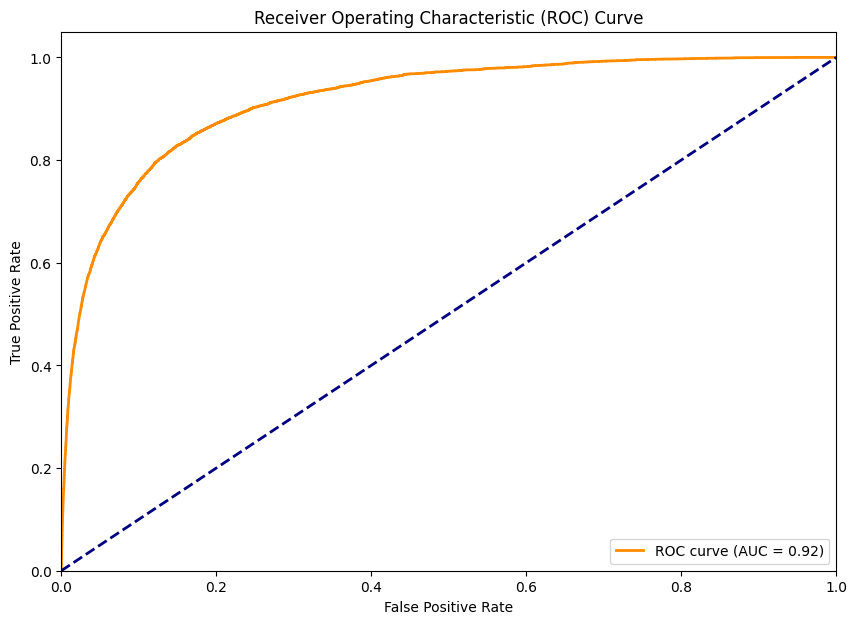

In [26]:
# ROC AUC 
fpr, tpr, thresholds = roc_curve(y_test, ensembled_probability)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

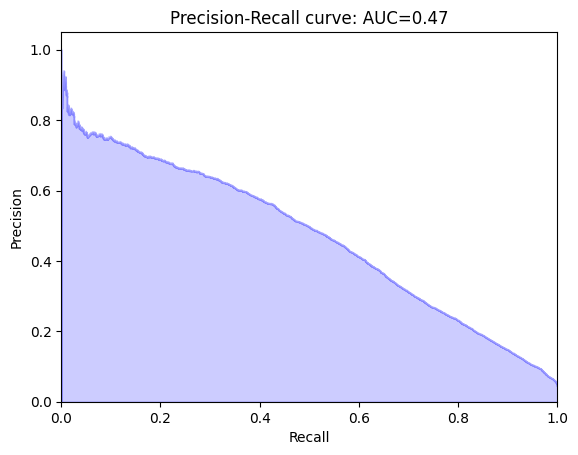

In [27]:
# Get predicted probabilities for the positive class (class 1)
from sklearn.metrics import average_precision_score, precision_recall_curve
# Calculate PR AUC
pr_auc = average_precision_score(y_test, ensembled_probability)

# Plot Precision-Recall curve (optional)
precision, recall, _ = precision_recall_curve(y_test, ensembled_probability)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(pr_auc))
plt.show()


In [28]:
average_precision_score(y_test, ensembled_probability)

0.46844102021439615

In [29]:
roc_auc

0.9171360492635685